In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install mosestokenizer

In [3]:
# colab　にmecabを入れる
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.4)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.7)
xz-utils is already installed at the requested version (5.2.2-1.3)
file is already installed at the requested version (1:5.32-2ubuntu0.2)
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main

In [0]:
import sys
import gc
import os
base_dir = "drive/My Drive/jp_en_translation/".replace("/",os.sep)
#base_dir = "../"
emb_dir = "drive/My Drive/util_data/".replace("/",os.sep)
sys.path.append("/Users/ueki/Desktop/work/jp_en_translation")
sys.path.append("/Users/ueki/Desktop/JP_EN_Transalation")
sys.path.append(base_dir)
sys.path.append("drive/My Drive/jp_en_translation".replace("/",os.sep))

In [3]:
from models.S2S_normalize import Seq2Seq
from utils.LangEn import LangEn
from utils.LangJa import LangJa
from utils.build_emb import build_en_emb,build_jp_emb
from utils.preprocess import loadLangs
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
import torch

Using TensorFlow backend.


In [0]:
config={
    "corpus_file":base_dir+"data/jpn.txt",
    "en_col":"description_en",
    "jp_col":"description_jp",
    "mask_token":0,
    "SOS_token":1,
    #"EOS_token":2,
    "EOS_token":0,
    "UNK_token":3,
    "max_features":8000,
    "MAX_LENGTH":20,
    "train_size":15000,
    "val_size":300,
    "batch_size":128,
    "epochs":20,
    "maxlen_enc":20,
    "maxlen_dec":20,
    "n_hidden":500,
    "input_dim":5000,
    "jp_voc":8000,
    "en_voc":5000,
    "output_dim":8000,
    "emb_dim":300,
    "use_enc_emb":False,
    "use_dec_emb":False,
    "validation_split":0.01,
    "trained_param_dir":base_dir+"trained_models/1_lstm_ja_en_01.hdf5",
    "translate_length":20,
    "en_W2V_FILE" : emb_dir+"GoogleNews-vectors-negative300.bin.gz",
    "jp_W2V_FILE":emb_dir+"ja_data/ja.bin",
    "src":"en",
    "trg":"jp",
    "learning_rate":0.001,
}

# train

In [5]:
data=loadLangs(config)

reading lines


In [0]:
val_data = data[config["train_size"]:config["train_size"]+config["val_size"]]
data = data[:config["train_size"]]

In [0]:
EN_lang = LangEn(config)
JP_lang = LangJa(config)

In [0]:
for s in data[config["en_col"]]:
    EN_lang.addSentence(s)

In [0]:
for s in data[config["jp_col"]]:
    JP_lang.addSentence(s)

## input の加工

In [0]:
if config["src"]=="jp":
    src_col=config["jp_col"]
    trg_col=config["en_col"]
    Langs={"src":JP_lang,"trg":EN_lang}
else:
    src_col=config["en_col"]
    trg_col=config["jp_col"]
    Langs={"trg":JP_lang,"src":EN_lang}

In [0]:
input_en = data[src_col]

In [0]:
input_source_lang=data[src_col].apply(lambda x:Langs["src"].word2id(x))
input_target_lang=data[trg_col].apply(lambda x:Langs["trg"].word2id(x))

In [0]:
val_source = val_data[src_col].apply(lambda x:Langs["src"].word2id(x))
val_target = val_data[trg_col].apply(lambda x:Langs["trg"].word2id(x))

In [0]:
input_source_padded=sequence.pad_sequences(input_source_lang,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")
input_target_padded=sequence.pad_sequences(input_target_lang,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")

In [0]:
val_source_padded=sequence.pad_sequences(val_source,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")
val_target_padded=sequence.pad_sequences(val_target,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## create embedding

In [0]:
#en_emb = build_en_emb(config,EN_lang.word2index)

In [0]:
#ja_emb = build_jp_emb(config,JP_lang.word2index)

In [0]:
#if config["src"]=="en":
#    emb={"src_emb":en_emb,"trg_emb":ja_emb}
#else:
  #  emb={"src_emb":ja_emb,"trg_emb":en_emb}

In [0]:
#print("enc->",emb["trg_emb"].shape)
#print("dec->",emb["src_emb"].shape)

In [0]:
#trainer = Seq2Seq(config,enc_emb=emb["src_emb"],dec_emb=emb["trg_emb"])
trainer = Seq2Seq(config)

train_size:15000 - val_size:300
Epoch 1/20
42 - loss: 0.73697 - val-loss: 1.00341
----------------
Epoch 2/20
42 - loss: 0.56398 - val-loss: 1.03478
----------------
Epoch 3/20
42 - loss: 0.48818 - val-loss: 0.88903
----------------
Epoch 4/20
42 - loss: 0.42239 - val-loss: 0.77217
----------------
Epoch 5/20
42 - loss: 0.35655 - val-loss: 0.90939
----------------
Epoch 6/20
42 - loss: 0.29942 - val-loss: 0.75251
----------------
Epoch 7/20
42 - loss: 0.24676 - val-loss: 0.82544
----------------
Epoch 8/20
42 - loss: 0.20110 - val-loss: 0.91071
----------------
Epoch 9/20
42 - loss: 0.16480 - val-loss: 0.57367
----------------
Epoch 10/20
42 - loss: 0.13381 - val-loss: 0.54346
----------------
Epoch 11/20
42 - loss: 0.10728 - val-loss: 0.89594
----------------
Epoch 12/20
42 - loss: 0.08309 - val-loss: 0.73744
----------------
Epoch 13/20
42 - loss: 0.06562 - val-loss: 0.78462
----------------
Epoch 14/20
42 - loss: 0.05030 - val-loss: 0.86518
----------------
Epoch 15/20
42 - loss: 0.

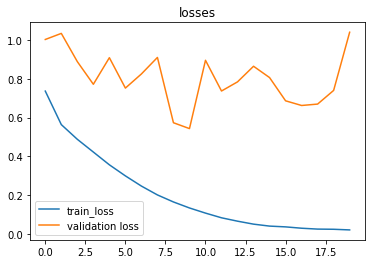

In [22]:
trainer.trainIters(input_source_padded,input_target_padded,val_source_padded,val_target_padded)

# test

In [0]:
ret=trainer.translateIter(val_source_padded[:10])

In [24]:
ret1 = trainer.translateIter(val_source_padded[:20])
for src,pred,target in zip(val_data[src_col],ret1,val_data[trg_col]):
    print("src->",src)
    print()
    print("pred->"," ".join(Langs["trg"].id2word(pred)))
    print("ans->",target)
    print("------------------")

src-> theres no need to hurry.

pred-> 急が なく て も いい よ 。 。 。 も いい よ 。 。 。 ・ で も いい 。
ans-> 急ぐ 必要 は あり ませ ん 。
------------------
src-> i want to join your band.

pred-> UNK たい 。 ほしい が 、 行き たい 。 。 UNK の 中 行き たい 。 だ 。 。 いい
ans-> あなた の バンド に 入り たい な 。
------------------
src-> you must keep an eye on the child.

pred-> 上司 で は 、 ドア を 閉め ず に いけ ず 。 困っ て ください 。 という 。 は 自分
ans-> その 子 から 目 を 離さ ない よう に し なけれ ば いけ ない 。
------------------
src-> he is mad about music.

pred-> 彼 は ４ ０ 歳 の ある 。 者 だ 。 いる 。 の 一 人 の 。 だ 。
ans-> 彼 は 音楽 狂 だ 。
------------------
src-> with a little more patience she would have succeeded.

pred-> あれ は 彼女 が 好き で 、 彼女 を もう少し の か どう に は し た だろ う 。
ans-> もし 彼女 が もう少し 我慢強かっ たら 、 成功 し て い た だろ う に 。
------------------
src-> they painted the fence green.

pred-> 彼ら は 値段 の ところ を 見 た 。 。 その 事故 を 出 た 。 。 メアリー に なっ
ans-> 彼ら は フェンス を 緑色 に 塗っ た 。
------------------
src-> there was a convention last month.

pred-> 昨日 の 間 に は 晴れ が い た 。 だっ た 。 説明 た 。 。 昨日 た 。
ans-> 先月 、 集会 が あっ た 。
-------

In [25]:
ret2 = trainer.translateIter(input_source_padded[:20])
for src,pred,target in zip(data[src_col],ret2,data[trg_col]):
    print("src->",src)
    print()
    print("pred->"," ".join(Langs["trg"].id2word(pred)))
    print("ans->",target)
    print("------------------")

src-> its tom.

pred-> トム だ 。 僕 が いい よ 。 ある 。 僕 が 見 て いる 。 。 信じ て い
ans-> トム だ 。
------------------
src-> id like to introduce you to some of my friends.

pred-> あなた を 私 の 友達 の 紹介 を し たい の です が 。 。 お て ください 。 です
ans-> あなた を 私 の 友達 に 紹介 し たい の です が 。
------------------
src-> please be careful.

pred-> 気 を つけ て ください 。 。 から お て ください 。 。 お 電話 で ください 。 。 だけ
ans-> 気 を つけ て ください 。
------------------
src-> he knows no english not to mention german.

pred-> 彼 は ドイツ 語 は 言うまでもなく 、 英語 も 知ら ない 。 まして も ない 。 だ 。 でも いい
ans-> 彼 は ドイツ 語 は 言うまでもなく 、 英語 も 知ら ない 。
------------------
src-> i explained the rules to her.

pred-> 私 は 彼女 に 規則 を 説明 し た 。 電話 を し た 。 い た 。 。 昨日
ans-> 私 は 彼女 に 規則 を 説明 し た 。
------------------
src-> the titanic sunk on its maiden voyage.

pred-> タイタニック 号 は 処女 航海 で 沈没 し た 。 そして の が 爆発 し た 。 だっ た 。
ans-> タイタニック 号 は 処女 航海 で 沈没 し た 。
------------------
src-> tom walked all day.

pred-> トム は 一 日 中 歩き 続け た 。 そして に なっ た 。 説明 た 。 説明 し た
ans-> トム は 一 日 中 歩き 続け た 。
------------------
src-> ma